In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/Face\ Detection\ \(personal\ project\)
!pwd

/content/gdrive/My Drive/Colab Notebooks/Face Detection (personal project)
/content/gdrive/My Drive/Colab Notebooks/Face Detection (personal project)


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Face Detection (personal project)/ipynb/')

In [4]:
import pandas as pd
import gc
import numpy as np
import tensorflow as tf
import keras
import os
from datetime import datetime as dt
from keras import layers, activations, models, optimizers, utils, regularizers, initializers
from keras.engine.input_layer import Input
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing import image
import keras.backend as K
from sklearn.metrics import accuracy_score, log_loss
import warnings
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import stl10_input
import FaceNetUtils as FNU

Using TensorFlow backend.


sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)


In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
train_parameters = {
    'name'    :'ResNet50_test',
    'seed'    :42,
    'base_lr' :0.005,
    'min_lr'  :0.0005,
    'lambda'  :0.00005,
    'momentum':0.9,
    'batch_size':32,
    'epochs'  :300,
    'schedule':'triangle',
    'period'  :10,
    'scaling' :0.9
    
}

now = dt.utcnow().strftime("%Y%m%d%H%M")
MODEL_SAVE_PATH = './models/ResNet_run{}.h5'.format(now)
LOGS_FILE = "run{}.csv".format(now)

In [0]:
DEST_DIR = './data/'
MODEL_DIR = './model/'
LOGS_DIR = './logs/'
DATA_PATH = './data/stl10_binary/train_X.bin'
LABEL_PATH = './data/stl10_binary/train_y.bin'
TEST_DATA_PATH = './data/stl10_binary/train_X.bin'
TEST_LABEL_PATH = './data/stl10_binary/train_y.bin'

In [0]:
dest_directory = LOGS_DIR
if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)

In [0]:
channels = [
    [64, 64, 256],
    [128, 128, 512],
    [256, 256, 1024],
    [512, 512, 2048]
]


input_ = Input(shape=(96,96,3))
x = layers.Conv2D(64,(7,7),kernel_initializer=initializers.he_normal(seed=train_parameters['seed']),strides=2, padding='same',kernel_regularizer=regularizers.l2(train_parameters['lambda']),name="block_0_cv_0")(input_)
x = layers.BatchNormalization(name="block_0_bn_0")(x)
x = layers.Activation('relu', name="block_0_relu_0")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="block_0_mp_0")(x)



x = FNU.conv_block(x, channels[0], train_parameters['lambda'], 1, strides=1 ,seed=train_parameters['seed'])
x = FNU.id_conv_block(x, channels[0], train_parameters['lambda'], 2, seed=train_parameters['seed'])
x = FNU.id_conv_block(x, channels[0], train_parameters['lambda'], 3, seed=train_parameters['seed'])
x = FNU.conv_block(x, channels[1], train_parameters['lambda'], 4, seed=train_parameters['seed'])
x = FNU.id_conv_block(x, channels[1], train_parameters['lambda'], 5, seed=train_parameters['seed'])
x = FNU.id_conv_block(x, channels[1], train_parameters['lambda'], 6, seed=train_parameters['seed'])
x = FNU.id_conv_block(x, channels[1], train_parameters['lambda'], 7, seed=train_parameters['seed'])
x = FNU.conv_block(x, channels[2], train_parameters['lambda'], 8, seed=train_parameters['seed'])
x = FNU.id_conv_block(x, channels[2], train_parameters['lambda'], 9, seed=train_parameters['seed'])
x = FNU.id_conv_block(x, channels[2], train_parameters['lambda'], 10, seed=train_parameters['seed'])
x = FNU.id_conv_block(x, channels[2], train_parameters['lambda'], 11, seed=train_parameters['seed'])
x = FNU.id_conv_block(x, channels[2], train_parameters['lambda'], 12, seed=train_parameters['seed'])
x = FNU.id_conv_block(x, channels[2], train_parameters['lambda'], 13, seed=train_parameters['seed'])
x = FNU.conv_block(x, channels[3], train_parameters['lambda'], 14, seed=train_parameters['seed'])
x = FNU.id_conv_block(x, channels[3], train_parameters['lambda'], 15, seed=train_parameters['seed'])
x = FNU.id_conv_block(x, channels[3], train_parameters['lambda'], 16, seed=train_parameters['seed'])
x = layers.AveragePooling2D(pool_size=(3, 3), strides=1)(x)#different from model to adapt to STL-10 // pool_size=(7, 7)
x = layers.Flatten()(x)
output_ = layers.Dense(10, activation='softmax', kernel_initializer=initializers.glorot_normal(seed=train_parameters['seed']))(x)

model = models.Model(inputs=input_, outputs=output_)
optimizer = optimizers.SGD(lr=train_parameters['base_lr'], momentum=train_parameters['momentum'],nesterov=True)

model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
block_0_cv_0 (Conv2D)           (None, 48, 48, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
block_0_bn_0 (BatchNormalizatio (None, 48, 48, 64)   256         block_0_cv_0[0][0]               
__________________________________________________________________________________________________
block_0_relu_0 (Activation)     (None, 48, 48, 64)   0           block_0_bn_0[0][0]               
__________________________________________________________________________________________________
block_0_mp

In [0]:
stl10_input.download_and_extract()

In [0]:
train_images = stl10_input.read_all_images(DATA_PATH)/255
print(train_images.shape)
train_labels = utils.to_categorical(stl10_input.read_labels(LABEL_PATH)-1)
print(train_labels.shape)
test_images = stl10_input.read_all_images(TEST_DATA_PATH)/255
print(test_images.shape)
test_labels = utils.to_categorical(stl10_input.read_labels(TEST_LABEL_PATH)-1)
print(test_labels.shape)

(5000, 96, 96, 3)
(5000, 10)
(5000, 96, 96, 3)
(5000, 10)


In [0]:
images = np.concatenate((train_images,test_images))
print(images.shape)
labels = np.concatenate((train_labels,test_labels))
print(labels.shape)

(10000, 96, 96, 3)
(10000, 10)


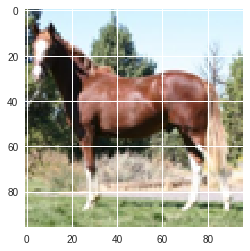

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [0]:
sample = np.random.randint(0,10000)
stl10_input.plot_image(images[sample])
labels[sample]

In [0]:
split = FNU.split_data(images, labels, 2000, 0, seed=train_parameters['seed'])
X_train, y_train, X_val, y_val = split[0:4]

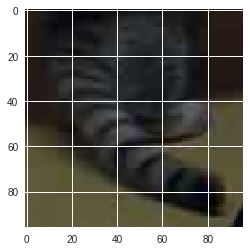

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


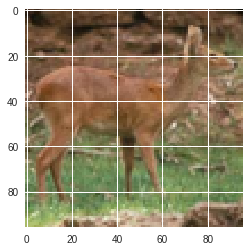

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [0]:
sample = np.random.randint(0,8000)
stl10_input.plot_image(X_train[sample])
print(y_train[sample])
sample = np.random.randint(0,2000)
stl10_input.plot_image(X_val[sample])
print(y_val[sample])

In [0]:
train_datagen = image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    data_format='channels_last')
val_datagen = image.ImageDataGenerator(data_format='channels_last')

In [0]:
scheduler = ReduceLROnPlateau(factor=train_parameters['scaling'],verbose=1) if train_parameters['schedule'] == 'step' else FNU.LR_scheduler(min_lr=train_parameters['min_lr'],period = train_parameters['period'], scale_factor=train_parameters['scaling'],schedule=train_parameters['schedule'])
callback_list = [scheduler, FNU.TrainLogger(train_parameters, LOGS_FILE, LOGS_DIR, max_y=2.0), 
                 ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=10)]

train_gen = train_datagen.flow(X_train, y_train, batch_size=train_parameters['batch_size'])
val_gen   = val_datagen.flow(X_val, y_val, batch_size=500)

model.fit_generator(train_gen, steps_per_epoch=int(np.ceil(len(X_train)/train_parameters['batch_size'])), validation_data=val_gen, validation_steps = 4,
                    epochs=train_parameters['epochs'],callbacks=callback_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/300
 15/250 [>.............................] - ETA: 4:51 - loss: 5.3777 - acc: 0.0958

KeyboardInterrupt: ignored

In [0]:
#callback_list = [FNU.LR_finder()]
#model.fit(x=images,y=labels, batch_size=train_parameters['batch_size'], epochs=4, validation_split=0.2, callbacks=callback_list)

In [0]:
#indexes_, logs = read_logs('./logs/epochs_logs/ep200_bs32_lr0.005_lamb0.0001_seed64_schtriangle_per10_scal0.9_blr0.0005.csv')

In [0]:
#callback_list[1].ShowLastRun()

In [0]:
callback_list[1].RunLogs(LOGS_DIR)